# Baseline script of SomaNews Clustering

In [2]:
import numpy as np
import pandas as pd
from konlpy.tag import Mecab
import hanja
import re
import string
import operator
import random
import matplotlib.pyplot as plt
import itertools
import cnouns
from sklearn.metrics import adjusted_rand_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from time import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from datetime import datetime
from sklearn.decomposition import PCA

In [6]:
mecab = Mecab()
mecab.nouns(u"한국은 검찰")
nouns = ' '.join(e for e in mecab.nouns(u"한국은 검찰"))

In [7]:
nouns

u'\ud55c\uad6d \uac80\ucc30'

## Load Data
Load Data from database

In [204]:
df = pd.read_pickle("../datastore/whole_articles.p")
df = df.drop(['author', 'link', 'imageURL'], axis=1)
df.shape

(120835, 8)

In [200]:
week_start = datetime.fromtimestamp(1472706898)
week_end = datetime.fromtimestamp(1473225298)

In [201]:
ws = df[df.publishedAt>=week_start]
we = ws[ws.publishedAt<=week_end]

In [202]:
cols = we.columns
vals = we.values
print len(cols), len(vals[0])
train_df = pd.DataFrame(vals, columns=cols)
train_df

8 8


,_id,category,content,description,provider,providerNewsID,publishedAt,title
0,57e2c849149c2181df5b92aa,nativeAD > CJ,CJ그룹이 7일부터 하반기 신입사원 1700명을 공개 채용한다. 작년보다 18% 늘...,,chosun,2016090701420,2016-09-07 11:31:00,"CJ그룹, 하반기 신입사원 1700명 공개 채용"
1,57e2c849149c2181df5b92ac,사회 > 카드뉴스,흙수저 출신 20대 억만장자의 '엉터리' 조언 기사보기 : http://goo.g...,,chosun,2016090701310,2016-09-07 10:59:00,[카드뉴스] 그의 수퍼카 부가티는 개미들의 눈물로 달렸을까요?
2,57e2c849149c2181df5b92ad,사회 > 카드뉴스,호주 역사상 처음!\n\n[ 조선일보 카드뉴스가 더 보고 싶다면 ?] \n\n[ 조...,,chosun,2016090701283,2016-09-07 10:49:00,[카드뉴스] 열한살 소년이 지폐를 바꿨습니다
3,57e2c849149c2181df5b92ae,사회 > 카드뉴스,한국프로야구 승부조작 \n[ 조선일보 카드뉴스가 더 보고 싶다면 ?] \n\n[ 조...,,chosun,2016090701173,2016-09-07 10:23:00,[카드뉴스] '원조 승부조작' 前 야구선수의 참회
4,57e2c849149c2181df5b92b0,사설ㆍ칼럼 > 내부칼럼 > 사설,추미애 더불어민주당 대표가 5일 취임 이후 첫 국회 교섭단체 연설에서 청와대에 '비...,,chosun,2016090603334,2016-09-07 03:23:00,[사설] 경제 앞길 막은 야당이 경제 失政 비판할 자격 있나
5,57e2c849149c2181df5b92b1,사설ㆍ칼럼 > 내부칼럼 > 사설,금융 공기업에 파견 근무 중인 김모 부장검사가 자신의 스폰서 역할을 해온 고교 동창...,,chosun,2016090603336,2016-09-07 03:19:00,"[사설] 檢察선 또 스폰서 검사, 法院선 또 돈 받고 재판"
6,57e2c84a149c2181df5b92b2,사설ㆍ칼럼 > 내부칼럼 > 사설,의료기관에서 C형 간염 집단감염 사태가 잇따르자 정부가 6일 C형 간염을 전수(全數...,,chosun,2016090603338,2016-09-07 03:18:00,"[사설] C형 간염, 의료기 再사용 병·의원 명단 공개해야"
7,57e2c84a149c2181df5b92b4,사설ㆍ칼럼 > 외부칼럼 > 시론ㆍ기고 > 朝鮮칼럼 The Column,대한민국을 건국한 동력은 무엇인가? 요즈음 벌어지고 있는 국가 정체성 논란의 핵심에...,최근 벌어진 국가 정체성 논란엔 '건국 동력 무엇인가' 핵심 있어\n민주주의·자본주...,chosun,2016090603347,2016-09-07 03:17:00,[朝鮮칼럼 The Column] 대한민국 건국 = 항일 + 반공
8,57e2c84a149c2181df5b92b5,사설ㆍ칼럼 > 내부칼럼 > 만물상,부산 초읍동 어린이대공원 뒤 백양산을 오르다 보면 높이 27m 거대한 석벽을 마주한...,,chosun,2016090603367,2016-09-07 03:16:00,[만물상] 음수사원(飮水思源)
9,57e2c84a149c2181df5b92b6,사설ㆍ칼럼 > 외부칼럼 > 정민의 세설신어,유관현(柳觀鉉·1692~1764)은 1759년 필선(弼善)의 직책으로 사도세자를 3...,,chosun,2016090603374,2016-09-07 03:15:00,[정민의 世說新語] [382] 난자이사 (難者二事)


In [203]:
train_df.to_pickle("../datastore/weekly_2.p")

## Pick test set

In [205]:
topics = {0: u'올림픽',
          1: u'테러', 
          2: u'브렉시트', 
#           3: u'남중국해, 사드, 북핵',
          3: u'미국 금리',
          4: u'바이러스', 
          5: u'미국대선,힐러리,트럼프', 
          6: u'시리아 전쟁, 난민', 
#           7: u'미국 금리'
         }
test_set = {}

In [206]:
ts0_1 = df.loc[df.title.str.match(u"(?=.*올림픽)(?!.*장애인)(?!.*평창).*")]
test_set[0] = pd.concat([ts0_1], axis=0)

In [207]:
test_set[1] = pd.concat([df.loc[df.title.str.match(u"(?=.*테러)(?!.*방지법).*")]], axis=0)

In [208]:
ts2_1 = df[df.title.str.match(u"(?=.*브렉시트).*")]
ts2_2 = df[df.title.str.match(u"(?=.*EU)(?=.*탈퇴).*")]
test_set[2] = pd.concat([ts2_1, ts2_2], axis=0)

In [209]:
# ts9_1 = df[df.title.str.match(u"(?=.*남중국해).*")]
# ts9_2 = df[df.title.str.match(u"(?=.*사드)(?=.*일본)(?!.*아사드).*")]
# ts9_3 = df[df.title.str.match(u"(?=.*사드)(?=.*중국)(?!.*아사드).*")]
# ts9_4 = df[df.title.str.match(u"(?=.*사드)(?=.*미국)(?!.*아사드).*")]
# ts9_5 = df[df.title.str.match(u"(?=.*사드)(?=.*시진핑)(?!.*아사드).*")]
# ts9_6 = df[df.title.str.match(u"(?=.*사드)(?=.*오바마)(?!.*아사드).*")]
# ts9_7 = df[df.title.str.match(u"(?=.*북핵).*")]
# test_set[3] = pd.concat([ts9_1, ts9_2, ts9_3, ts9_4, ts9_5, ts9_6, ts9_7], axis=0)

In [210]:
ts4_1 = df[df.title.str.match(u"(?=.*지카).*")]
ts4_2 = df[df.title.str.match(u"(?=.*메르스).*")]
ts4_3 = df[df.title.str.match(u"(?=.*에볼라).*")]
ts4_4 = df[df.title.str.match(u"(?=.*바이러스).*")]
test_set[4] = pd.concat([ts4_1, ts4_2, ts4_3, ts4_4], axis=0)

In [211]:
ts5_1 = df[df.title.str.match(u"(?=.*힐러리).*")]
ts5_2 = df[df.title.str.match(u"(?=.*트럼프).*")]
ts5_3 = df[df.title.str.match(u"(?=.*클린턴).*")]
ts5_4 = df[df.title.str.match(u"(?=.*도날드)(?!.*맥도날드).*")]
test_set[5] = pd.concat([ts5_1, ts5_2, ts5_3, ts5_4], axis=0)

In [212]:
ts6_1 = df[df.title.str.match(u"(?=.*시리아).*")]
ts6_2 = df[df.title.str.match(u"(?=.*알레포).*")]
ts6_3 = df[df.title.str.match(u"(?=.*아사드).*")]
ts6_4 = df[df.title.str.match(u"(?=.*정부군).*")]
ts6_5 = df[df.title.str.match(u"(?=.*반군).*")]
ts3_6 = df[df.title.str.match(u"(?=.*난민).*")]
test_set[6] = pd.concat([ts6_1, ts6_2, ts6_3, ts6_4, ts6_5, ts3_6], axis=0)

In [213]:
ts8_1 = df[df.title.str.match(u"(?=.*연준).*")]
# ts8_2 = df[df.title.str.match(u"(?=.*양적완화)(?!.*한국).*")]
ts8_3 = df[df.title.str.match(u"(?=.*금리)(?=.*인상).*")]
ts8_4 = df[df.title.str.match(u"(?=.*기준)(?=.*금리).*")]
ts8_5 = df[df.title.str.match(u"(?=.*옐런).*")]
ts8_6 = df[df.title.str.match(u"(?=.*금리)(?=.*동결).*")]
ts8_7 = df[df.title.str.match(u"(?=.*금리)(?=.*경제).*")]
test_set[3] = pd.concat([ts8_1, ts8_3, ts8_4, ts8_5, ts8_6, ts8_7], axis=0)

In [214]:
# ts7_1 = df[df.title.str.match(u"(?=.*IS).*")]
# ts7_2 = df[df.title.str.match(u"(?=.*극단주의).*")]
# ts7_3 = df[df.title.str.match(u"(?=.*외로운 늑대).*")]
# test_set[7] = pd.concat([ts7_1, ts7_2, ts7_3], axis=0)

In [215]:
# ts9_1 = df[df.title.str.match(u"(?=.*남중국해).*")]
# ts9_2 = df[df.title.str.match(u"(?=.*사드)(?=.*일본)(?!.*아사드).*")]
# ts9_3 = df[df.title.str.match(u"(?=.*사드)(?=.*중국)(?!.*아사드).*")]
# ts9_4 = df[df.title.str.match(u"(?=.*사드)(?=.*미국)(?!.*아사드).*")]
# ts9_5 = df[df.title.str.match(u"(?=.*사드)(?=.*시진핑)(?!.*아사드).*")]
# ts9_6 = df[df.title.str.match(u"(?=.*사드)(?=.*오바마)(?!.*아사드).*")]
# ts9_7 = df[df.title.str.match(u"(?=.*북핵).*")]
# test_set[9] = pd.concat([ts9_1, ts9_2, ts9_3, ts9_4, ts9_5, ts9_6, ts9_7], axis=0)

In [216]:
for i in range(0, len(topics)):
    test_set[i]['topic'] = topics[i]
    test_set[i]['topic_idx'] = i
#     test_set[i] = test_set[i].sample(n=150)
    
test_set[5] = test_set[5].sample(n=500)

concat_df = pd.concat([ts for ts in test_set.values()], axis=0)
cols = concat_df.columns
vals = concat_df.values
print len(cols), len(vals[0])
train_df = pd.DataFrame(vals, columns=cols)
len(train_df)
train_df.title.head

10 10


<bound method Series.head of 0                         "올림픽 잘해보자" 韓·中·日 장관 내일 만난다
1                               한화 올림픽 사격 메달리스트에 포상금
2                             전인지 “도쿄올림픽선 메달 꼭 깨물래요”
3                          패럴림픽 육상 3등이 올림픽 1등보다 빠르다니
4                    [스포츠 브리핑] 쑨양 "도쿄올림픽서 金 더 따고 은퇴"
5                           코리아오픈테니스 19일부터 올림픽코트서 열려
6                              도쿄올림픽 야구, 후쿠시마서 경기 추진
7                           [2030 프리즘] '아베 마리오'의 올림픽
8                            [2030 프리즘] 망한 올림픽이 준 위로
9                                     올림픽이 끝나니 각국에선…
10                           [데스크에서] 해킹 올림픽 2連覇 막은 敵
11        [생각해봅시다­-올림픽과 학교체육 현실] 묘목에 무관심한 채 열매 바라는 격
12      [생각해봅시다­-올림픽과 학교체육 현실] 초등 체육 시간에 다른 과목 보충한다니
13                         "한국 배구, 이러다간 도쿄올림픽도 못 나가"
14                   "국내 대회 '쇼핑' 바쁜 한국 마라톤, 올림픽은 뒷전"
15                  [카드뉴스] 리우올림픽 폐막식에 등장한 슈퍼 마리오의 정체
16                          [카드뉴스] 아직 올림픽은 끝나지 않았습니다
17                       박인비·리디아 고 명승부… 올림픽 골프 흥행 성공
18               

In [217]:
train_df.to_pickle("../datastore/international.p")

## Preprocessing
1. Remove stopwords (regex, hanja)
2. POS Tagging with KoNLPy, Mecab

In [ ]:
def text_cleaning(text):
    text = hanja.translate(text, 'substitution')
    text = re.sub(u'(\[.*\]|\(.*\))', '', text)
    text = re.sub(u'(\(|\)|\[|\])', '', text)
    return text

In [ ]:
# train_df.title.head()

In [67]:
train_df['clean_title'] = [cnouns.text_cleaning(t) for t in train_df.title]
train_df['clean_content'] = [cnouns.text_cleaning(t) for t in train_df.content]

In [68]:
train_df['tokenized_title'] = [cnouns.tokenize(t) for t in train_df.clean_title]
train_df['tokenized_content'] = [cnouns.tokenize(t) for t in train_df.clean_content]

## Save/Load Preprocessed data

In [ ]:
train_df.to_pickle("../datastore/preprocesse.p")

In [ ]:
train_df = pd.read_pickle("../datastore/preprocesse.p")

In [ ]:
train_df.head

## Training

In [69]:
vectorizer = TfidfVectorizer(lowercase=False, 
                             max_features=None,
                             max_df=1.0, 
                             min_df=1,
                             use_idf=True,
                             smooth_idf=True,
                             sublinear_tf=False)

In [70]:
x_list = vectorizer.fit_transform(train_df.tokenized_title + train_df.tokenized_content)

In [71]:
print x_list.shape
print train_df.shape

(3107, 826351)
(3107, 14)


In [72]:
x_list[0]

<1x826351 sparse matrix of type '<type 'numpy.float64'>'
	with 229 stored elements in Compressed Sparse Row format>

In [73]:
# len(x_list.toarray())
# print(dict(zip(vectorizer.get_feature_names(), vectorizer._tfidf.idf_)))
# x_list.stop_words()

### Basic Models
1. Tf-idf and Cosine similarity
2. K-Means Algorithm

In [74]:
def cosine_distance(x_list):
    dist = 1 - cosine_similarity(x_list)
    return dist

In [75]:
num_clusters = len(topics)
num_clusters

7

In [103]:
t0 = time()
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
km.fit(x_list)
clusters = km.labels_.tolist()
print("Done in %0.3fs." % (time() - t0))

Done in 20.074s.


In [104]:
print(len(clusters), len(train_df))

(3107, 3107)


In [105]:
train_df['cluster'] = clusters

In [79]:
def match_cluster_topic(train_df, is_cluster, topics):
    if(is_cluster):
        print("Cluster -> Topic")
        criteria = 'cluster'
        target = 'topic_idx'
    else:
        print("Topic -> Cluster")
        criteria = 'topic_idx'
        target = 'cluster'
        
    total_doc = 0    
    total_accuracy = 0    
    for i in range(0, num_clusters):
        criteria_set = train_df[train_df[criteria]==i]
        target_count = {}
        for j in range(0, num_clusters):
            target_set = criteria_set[criteria_set[target]==j]
            target_count[j] = len(target_set)
        max_target_idx = max(target_count.iteritems(), key=operator.itemgetter(1))[0]
        accuracy = 100*target_count[max_target_idx]/float(len(criteria_set))
        total_accuracy = total_accuracy + accuracy
        if(is_cluster):
            topic_str = topics[max_target_idx]
        else:
            topic_str = topics[i]
        print("#%d -> #%d Accuracy is %.4d/%.4d = %.10f \t %s" % (i, max_target_idx, target_count[max_target_idx], len(criteria_set), accuracy, topic_str))
        total_doc = total_doc + target_count[max_target_idx]
        
    print("%.4f" % (total_accuracy/num_clusters))
    print("%.4f" % (100 * total_doc/len(train_df)))

In [80]:
def print_topics():
    for idx in topics:
        topic = topics[idx]
        print("%.4d - %s" % (len(train_df[train_df.topic==topic]), topic)) 

In [106]:
match_cluster_topic(train_df, True)

Cluster -> Topic
#0 -> #0 Accuracy is 0639/1044 = 61.2068965517 	 올림픽
#1 -> #4 Accuracy is 0252/0271 = 92.9889298893 	 바이러스
#2 -> #2 Accuracy is 0205/0218 = 94.0366972477 	 브렉시트
#3 -> #6 Accuracy is 0198/0213 = 92.9577464789 	 시리아 전쟁, 난민
#4 -> #3 Accuracy is 0201/0206 = 97.5728155340 	 미국 금리
#5 -> #5 Accuracy is 0450/0468 = 96.1538461538 	 미국대선,힐러리,트럼프
#6 -> #1 Accuracy is 0511/0687 = 74.3813682678 	 테러
87.0426
79.0000


In [107]:
match_cluster_topic(train_df, False)

Topic -> Cluster
#0 -> #0 Accuracy is 0639/0669 = 95.5156950673 	 올림픽
#1 -> #6 Accuracy is 0511/0610 = 83.7704918033 	 테러
#2 -> #2 Accuracy is 0205/0236 = 86.8644067797 	 브렉시트
#3 -> #4 Accuracy is 0201/0219 = 91.7808219178 	 미국 금리
#4 -> #1 Accuracy is 0252/0420 = 60.0000000000 	 바이러스
#5 -> #5 Accuracy is 0450/0500 = 90.0000000000 	 미국대선,힐러리,트럼프
#6 -> #3 Accuracy is 0198/0453 = 43.7086092715 	 시리아 전쟁, 난민
78.8057
79.0000


In [83]:
# print_top_words(km, vectorizer.get_feature_names(), 20)

In [84]:
adjusted_rand_score(train_df.topic, km.labels_)

0.5376391284027876

In [ ]:
# skf = StratifiedKFold(range(num_clusters), n_folds=3)
# cross_val_score(km, x_list)

In [ ]:
df = train_df.drop(['_id', 'content', 'description', 'provider', 'providerNewsID', 'publishedAt'], axis=1)
two = df[df.cluster==3]
# two[two.topic_idx==4]
for idx in topics:
    print topics[idx], len(two[two.topic_idx==idx])
# two

In [ ]:
two

In [85]:
def get_cartesian(df):
    cartesian = itertools.product(range(num_clusters), range(num_clusters))

    temp = {
        'cluster': [],
        'topic_idx': [],
        'counts': []
    }
    for c, t in cartesian:
        tmp_clusters = df[df.cluster==c]
        tmp_topics = tmp_clusters[tmp_clusters.topic_idx==t]
        temp['cluster'].append(c)
        temp['topic_idx'].append(t)
        temp['counts'].append(len(tmp_topics))

    results = pd.DataFrame(temp)
    results = results[results.counts!=0]
    
    return results

In [ ]:
results = get_cartesian(df)

In [86]:
def show_cartesian(df):
    results = get_cartesian(df)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(results.topic_idx, results.cluster, 'ro')
    for index, row in results.iterrows():
        x = row['topic_idx']
        y = row['cluster']
        ax.annotate('  %d' % row['counts'], xy=(x,y), textcoords='data')
    plt.axis([-1, 7, -1, 7])
    plt.xlabel('Topic')
    plt.ylabel('Cluster')

    plt.grid()
    plt.show()

In [16]:
def show_cluster(df, num):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(df.cluster, df.cluster, 'ro')
    for n in range(num):
        count = len(df[df.cluster==n])
        ax.annotate('  %d' % count, xy=(n,n), textcoords='data')

#     plt.axis([-1, 7, -1, 7])
#     plt.xlabel('Topic')
#     plt.ylabel('Cluster')

    plt.grid()
    plt.show()

In [88]:
show_cluster(train_df)

TypeError: show_cluster() takes exactly 2 arguments (1 given)

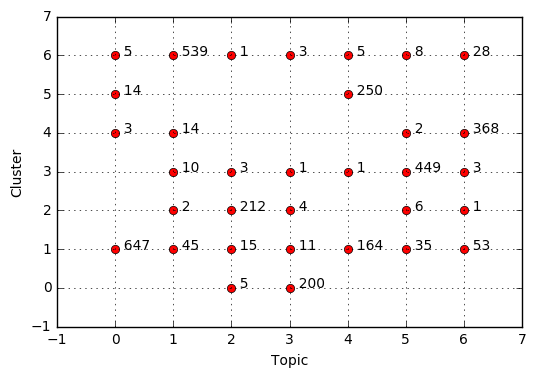

In [95]:
show_cartesian(train_df)

## Deep Learning

In [17]:
from gensim import models
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
import gensim.models.doc2vec
from gensim.models.doc2vec import LabeledSentence
from collections import OrderedDict
import multiprocessing
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

from random import shuffle

from collections import namedtuple

Articles = namedtuple('Articles', 'words tags split')

In [18]:
size = len(train_df) / 4
print size, len(train_df), size * 4

590 2360 2360


In [19]:
train_df.shape

(2360, 12)

In [20]:
# import MeCab
# MeCab.__file__

In [21]:
alldocs = []
for idx, row in train_df.iterrows():
    tokens = row['tokenized_title'].split(' ') + row['tokenized_content'].split(' ')
    words = tokens[1:] # why start from 1?
    tags = [idx] # `tags = [tokens[0]]` would also work at extra memory cost
#     label = [idx]
    tmp = idx//size % 4
    split = ['train','test','extra','extra'][tmp]  # 25k train, 25k test, 25k extra
#     sentiment = [1.0, 0.0, 1.0, 0.0, None, None, None, None][tmp] # [12.5K pos, 12.5K neg]*2 then unknown
    alldocs.append(Articles(words, tags, split))
#     alldocs.append(LabeledSentence(words, label))

In [22]:
# train_docs = [doc for doc in alldocs if doc.split == 'train']
# test_docs = [doc for doc in alldocs if doc.split == 'test']
doc_list = alldocs[:]  # for reshuffling per pass

# print('%d docs: %d train, %d test' % (len(doc_list), len(train_docs), len(test_docs)))

In [23]:
# words = [x.words for x in alldocs]
# w2v = Word2Vec(words, size=100, window=5, min_count=5, workers=4)
# w2v.save_word2vec_format("../datastore/w2v.p")

In [24]:
simple_models = [
    # PV-DM Distributed Momory Model of PV
    # w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW Distributed Bag of Words version of PV
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DM w/average
    Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
]

In [25]:
simple_models[0].load_word2vec_format("../datastore/w-w2v.p")

In [26]:
print len(alldocs)
# alldocs[0]

2360


In [27]:
# speed setup by sharing results of 1st model's vocabulary scan
simple_models[0].build_vocab(alldocs)  # PV-DM/concat requires one special NULL word so it serves as template

In [28]:
len(simple_models[0].docvecs)

2360

In [29]:
print simple_models[0]
for model in simple_models[1:]:
    model.reset_from(simple_models[0])
    print(model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
Doc2Vec(dbow,d100,n5,mc2,t8)
Doc2Vec(dm/m,d100,n5,w10,mc2,t8)


In [30]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[1], simple_models[2]])
models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[1], simple_models[0]])

In [31]:
alpha, min_alpha, passes = (0.025, 0.001, 20)
alpha_delta = (alpha - min_alpha) / passes

for epoch in range(passes):
    shuffle(doc_list)  # shuffling gets best results

    for name, train_model in models_by_name.items():
        train_model.alpha, train_model.min_alpha = alpha, alpha
        train_model.train(doc_list)
        print("%i passes : %s" % (epoch + 1, name))

    print('completed pass %i at alpha %f' % (epoch + 1, alpha))
    alpha -= alpha_delta

1 passes : Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
1 passes : Doc2Vec(dbow,d100,n5,mc2,t8)
1 passes : Doc2Vec(dm/m,d100,n5,w10,mc2,t8)
1 passes : dbow+dmm
1 passes : dbow+dmc
completed pass 1 at alpha 0.025000
2 passes : Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
2 passes : Doc2Vec(dbow,d100,n5,mc2,t8)
2 passes : Doc2Vec(dm/m,d100,n5,w10,mc2,t8)
2 passes : dbow+dmm
2 passes : dbow+dmc
completed pass 2 at alpha 0.023800
3 passes : Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
3 passes : Doc2Vec(dbow,d100,n5,mc2,t8)
3 passes : Doc2Vec(dm/m,d100,n5,w10,mc2,t8)
3 passes : dbow+dmm
3 passes : dbow+dmc
completed pass 3 at alpha 0.022600
4 passes : Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
4 passes : Doc2Vec(dbow,d100,n5,mc2,t8)
4 passes : Doc2Vec(dm/m,d100,n5,w10,mc2,t8)
4 passes : dbow+dmm
4 passes : dbow+dmc
completed pass 4 at alpha 0.021400
5 passes : Doc2Vec(dm/c,d100,n5,w5,mc2,t8)
5 passes : Doc2Vec(dbow,d100,n5,mc2,t8)
5 passes : Doc2Vec(dm/m,d100,n5,w10,mc2,t8)
5 passes : dbow+dmm
5 passes : dbow+dmc
completed pass 5 at alpha

In [ ]:
# for name, train_model in models_by_name.items():
#     text = name.split(',')
#     filename = re.sub(u'(\(|/|Doc2Vec)', '', text[0])
#     train_model.save("../datastore/d2v-" + filename)
#     print filename

In [ ]:
models_by_name['Doc2Vec(dm/c,d100,n5,w5,mc2,t8)'].save("../datastore/d2v-dmc")
models_by_name['Doc2Vec(dbow,d100,n5,mc2,t8)'].save("../datastore/d2v-dbow")
models_by_name['Doc2Vec(dm/m,d100,n5,w10,mc2,t8)'].save("../datastore/d2v-dmm")

In [32]:
dm = models_by_name['dbow+dmm']

In [33]:
doc_arr = dm.docvecs

In [34]:
len(doc_arr)

TypeError: object of type 'ConcatenatedDocvecs' has no len()

In [ ]:
# dm[u"테러"]

In [ ]:
for t in dm.most_similar(u"테러"):
    print t[0], t[1]

In [ ]:
# model.docvecs[31]

In [35]:
def test_sims(test_idx, threadsold=0.5, is_last = False):
    sims = model.docvecs.most_similar(test_idx, topn=len(model.docvecs))
    most_sims = [s for s in sims if s[1]>threadsold]
    last_sims = most_sims[len(most_sims)-5:]
    print "sims -", len(sims), ", most_sims -", len(most_sims)
    print train_df.loc[test_idx].title
    print "\n"
    if(is_last):
        for s in last_sims:
            print train_df.loc[s[0]].title
    else:
        for s in most_sims:
            print train_df.loc[s[0]].title

In [36]:
test_sims(5)

sims - 2359 , most_sims - 139
[사설] 檢察선 또 스폰서 검사, 法院선 또 돈 받고 재판


[사설] ‘스폰서 검사’ 뭉갠 검찰, 자정능력 의심된다
"검사實名 다 밝힌다"는 스폰서… 그 입에 달린 검찰 명예
[단독] 이번엔 ‘스폰서 부장검사’ 의혹....수사검사에 사건무마 청탁
[단독] “싼 집이라 진술해라” 스폰서 부장검사, 조작·은폐 시도
[사설]검찰총장은 ‘스폰서 부장검사’ 보고받고도 뭉갰나
스폰서 의혹 부장검사, 서울고검으로 전보
[단독] 스폰서 부장검사 ‘셀프고소’ 유도에 ‘전관’ 알선까지
서부지검, 귀찮을 정도로 전화 와도 '사건무마' 청탁 방치
현직 부장검사 ‘스폰서’ 사업가에 구속영장 발부
대검, ‘부장검사 비리’ 보고받고도 감찰 안했다
“약점 하나 잡혀… 협박하는 동창, 악마 같았다”
[오늘의 채널A]바람 잘 날 없는 검찰
개혁선언 1주일도 안돼 '스폰서 검사' 의혹
[단독] 지인 변호사 아내 계좌로 1천만원, 술집 종업원 계좌로 500만원 왜?
대검, ‘스폰서 부장검사’ 특별감찰팀 구성
스폰서 의혹 부장검사 ‘동창과의 단순 대차관계’ 주장하지만...
법무부 ‘스폰서 부장검사’ 2개월 직무정지 명령…감찰 본격화
[뉴스룸 토크] 검사에게 술이란 무엇인가
현직 부장검사 스폰서 사업가 “반성하고 있다”
[단독] “부장검사 스폰서 역할 했다” 진술 듣고도 검찰은 ‘모르쇠’
[단독]檢개혁안 5일만에 또 불거진 ‘스폰서 검사’
김형준 검사 “7억 스폰? 그런 말 하면 난 한강 뛰어들어야”
'부장판사 수뢰' 꽃놀이패 쥐고 골탕 먹이나… 법원, 검찰에 부글
[단독] 스폰서 부장검사, ‘셀프고소’ 접수전 고양지청 찾아 ‘자기변론’
‘돈’에 무너진 ‘法’
[뉴스룸 토크] 검사와 친구
1500만원 받은뒤 수사팀과 점심… 대검, 석달前 알고도 뒷짐
[단독] 스폰서 부장검사 “너 영장 기각되려면 내 손 풀려 있어야”
'레인지로버 부장판사' 구속… 대법원 "뼈저리게 반성"
[뉴스룸 토크] 검사와 돈
서부지검·대검 해명 오락가락…‘봐주기 수사’ 책

In [37]:
len(model.docvecs)
inp = np.array(model.docvecs)
# type(x_list)

In [38]:
best_score = 0.0
best_k = 0

In [ ]:
for k in range(50, 60):
    t_km = KMeans(n_clusters=k, n_jobs=-1).fit(inp)
    score = silhouette_score(inp, t_km.labels_)
    if best_score < score:
        best_score = score
        best_k = k
    print("In Clusters =", k, ", Score is : %0.3f" % score)
print("In Clusters =", best_k, ", Best score is : %0.3f" % best_score)

In [ ]:
for s in most_sims:
    print train_df.loc[s[0]].title

In [39]:
d_km = KMeans(n_clusters=10, n_jobs=-1)
d_km.fit(inp)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [ ]:
inp.shape

In [ ]:
# d_sc = SpectralClustering(10)
# d_sc.fit(inp)

In [ ]:
d_ac = AgglomerativeClustering(n_clusters=20, affinity='cosine', linkage='average')
d_ac.fit(inp)

In [ ]:
d_dc = DBSCAN(min_samples=1)
d_dc.fit(inp)

In [ ]:
clusters = d_dc.labels_.tolist()

In [112]:
n_cluster = 200

In [113]:
d_km = KMeans(n_clusters=n_cluster, n_jobs=-1)
d_km.fit(inp)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=200, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [114]:
clusters = d_km.labels_.tolist()

In [115]:
print len(clusters)
clusters[:10]

2360


[150, 151, 151, 151, 20, 27, 23, 182, 72, 151]

In [124]:
d_train_df = train_df

In [125]:
train_df.shape

(2360, 8)

In [126]:
d_train_df['cluster'] = clusters

In [127]:
# show_cluster(d_train_df, n_cluster)

In [128]:
print model.docvecs.similarity(d1=110, d2=175)
print model.docvecs.similarity(d1=233, d2=274)

0.555331984576
0.555344840467


In [129]:
test_sims(110, threadsold=0.5, is_last = False)

sims - 2359 , most_sims - 157
더 뾰족해진 노동미사일 탄두… 개량한 듯


北 노동미사일 개량해 정밀도 높인듯
韓·中정상회담 2시간 후… 노동미사일 3발 쏜 김정은
북, 탄도미사일 3발 동해상으로 발사…노동미사일 추정
유엔 안보리, 북한 미사일 발사에 6일 긴급회의 소집
5일 쏜 북 미사일, ‘노동’이냐, ‘스커드’냐
北, 한중 정상 만난 날 미사일 시위
3발 모두 1000km 날아가… 北, 노동미사일까지 성공
노동미사일 3발 1000㎞ 날아… 駐日 미군기지 동시타격 능력 과시
北 탄도미사일 발사… 또 사전감지 못한 日, MD 강화론 힘 실려
북 김정은 “핵무력 강화 계속 확대”…미사일 발사훈련 지도
北, 선전 극대화 노려 SLBM 추가 도발 가능성
“북한, SLBM  완성 전 실전배치 선언할 수도”
"北 SLBM, 中 SLBM과 완전히 똑같아"
유엔 안보리, ’북 미사일 발사 규탄’ 언론 성명 채택
박 대통령-시진핑, ‘사드·북핵회담’ 종료…46분 진행
“北 우라늄 농축 원심분리기, 日 재처리시설 모델로 제작”
"사드 등 강력한 對北 억지력 유지"
美 해병대 "F-35 등 주력機에 레이저 무기 장착"
한-미 정상 “사드는 북핵 대응 위한 것”
시진핑-아베 “대화 지속” 밝혔지만…
“北 우방국들 외교관 추방-교역중단 잇달아”
朴대통령과 오바마, 고별 회담의 키워드는 '사드·北인권'
시진핑, 박근혜 대통령에 “사드 반대”
'한국형 사드' 탄도탄 요격 미사일, 2023년 양산 들어간다
박 대통령 “북 핵 위협 제거되면 사드 배치 필요성도 없어질 것”
박 대통령 “북핵 위협 제거되면 사드 필요성도 없어질 것”
박 대통령, 5일 오전 시진핑 주석과 한-중 정상회담
'한국형 사드' 탄도탄 요격 미사일, 2023년 양산 들어간다
박 대통령, 러시아·중국·미국 연쇄 정상회담
김천 주민 대표단 韓국방 첫 면담… "제3부지 못 받아들여"
[사설]한미정상의 “사드 배치” 재확인, 北-中은 무겁게 여겨야
한미 “사드로 北도발 강력 억지”
朴대통령·시진핑 '

In [175]:
from operator import itemgetter
sized = [(n, len(d_train_df[d_train_df.cluster==n])) for n in range(n_cluster)]
sort1 = sized[:]
sort1.sort(key=lambda x: -x[1])


In [176]:
sort1

[(151, 233),
 (6, 90),
 (18, 69),
 (12, 56),
 (95, 56),
 (150, 54),
 (19, 52),
 (76, 45),
 (54, 41),
 (72, 39),
 (10, 38),
 (26, 36),
 (33, 35),
 (47, 35),
 (97, 35),
 (155, 32),
 (73, 30),
 (90, 30),
 (132, 30),
 (3, 29),
 (63, 29),
 (44, 28),
 (75, 27),
 (92, 27),
 (175, 27),
 (108, 26),
 (27, 24),
 (38, 24),
 (99, 24),
 (14, 23),
 (48, 23),
 (168, 23),
 (16, 22),
 (11, 21),
 (40, 21),
 (89, 21),
 (7, 20),
 (21, 20),
 (128, 20),
 (20, 19),
 (23, 19),
 (59, 19),
 (1, 18),
 (13, 18),
 (35, 18),
 (186, 18),
 (189, 18),
 (58, 17),
 (117, 17),
 (121, 17),
 (4, 16),
 (114, 16),
 (2, 15),
 (32, 15),
 (46, 15),
 (88, 15),
 (160, 15),
 (15, 13),
 (25, 13),
 (82, 13),
 (86, 13),
 (182, 13),
 (5, 12),
 (36, 12),
 (45, 12),
 (126, 12),
 (49, 11),
 (69, 11),
 (131, 11),
 (142, 11),
 (180, 11),
 (187, 11),
 (30, 9),
 (127, 9),
 (170, 9),
 (173, 9),
 (41, 8),
 (61, 8),
 (66, 8),
 (139, 8),
 (144, 8),
 (174, 8),
 (24, 7),
 (37, 7),
 (84, 7),
 (8, 6),
 (68, 6),
 (83, 6),
 (133, 6),
 (145, 6),
 (183, 

In [187]:
center = d_km.cluster_centers_[151]
a = inp[0] - center
sum(a * a)

452.28065900911213

In [194]:
# d_km.cluster_centers_[151]

In [197]:
center = d_km.cluster_centers_[12]
def vdist(v):
    dv = v - center
    return sum(dv * dv)

dists = [vdist(v) for v in inp]
i = dists.index(min(dists))
print d_train_df.loc[i].title

'친환경 벽지' 공급, 환경경영 실천


In [196]:
d_train_df[d_train_df.cluster==12].title

48                                술 한모금 삼키자 핀란드 숲향 가득
255                           신선도 유지 위해 브라질 현지서 가공·생산
375                  대륙 진출 20년… 2017년까지 年 매출 1000억 목표
376                              '친환경 벽지' 공급, 환경경영 실천
379                    알러지 유발 없는 마스크 팩, 누적 판매량 6억장 돌파
380                         창립 19주년… 가성비 높인 상품 개발로 승부
381                      '한방 3대 약초' 구기자… 간 기능·항산화에 도움
382                        '중화권 최대 관광시장' 홍콩·마카오 본격 공략
383                                 차별화된 맛으로 세계를 사로잡다
384                      외국어 초보자도 쉽고 재밌게… 단어연결법 학습 강의
385                                 건전한 음주문화와 대학생활 선도
388                            할랄 인증 획득… 이슬람권 수출 길 열어
389                   亞 최대 규모 도심형 아웃렛… 패션·가구 등 원스톱 쇼핑
392                       서민형 퓨전 포장마차… 전국 200개 가맹점 운영
393                          한류체험공간 설치, 쇼핑 이상의 즐거움 선사
395                    주부 라이프스타일 연구… 3050을 위한 여성복 선보여
396                       성수기 회원 예약 우선권 제공 등 차별화된 서비스
397                    고품질·합리적인 가격… 세븐카페, 원두 커피 시장 돌풍
398                         

In [52]:
d_train_df.columns
# train_df.cluster

Index([              u'_id',          u'category',           u'content',
             u'description',          u'provider',    u'providerNewsID',
             u'publishedAt',             u'title',       u'clean_title',
           u'clean_content',   u'tokenized_title', u'tokenized_content',
                 u'cluster'],
      dtype='object')

In [ ]:
match_cluster_topic(d_train_df, False)

In [ ]:
match_cluster_topic(d_train_df, True)

In [ ]:
show_cartesian(d_train_df)

In [ ]:
adjusted_rand_score(d_train_df.topic, d_km.labels_)

In [ ]:
range(num_clusters)

In [ ]:
# model.docvecs.shape

In [ ]:
# d_skf = StratifiedKFold(range(num_clusters), n_folds=3)
# cross_val_score(d_km, model.docvecs, cv=d_skf)

In [ ]:
print_topics()

In [ ]:
d_train_df[d_train_df.cluster==1].title